# Import Packages

In [1]:
# General
import os
import numpy as np
import math
import pandas as pd

# Plotting
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

# Astropy
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Scipy
from scipy.integrate import trapz
from scipy.optimize import fsolve
from scipy import interpolate

# PyCloudy
import pyCloudy as pc

# Plotting theme
plt.style.use('./thesis.mplstyle')

## To ignore the annoying warnings:

1) Find the relevant pyCloudy file - for me it was /opt/anaconda3/lib/python3.8/site-packages/pyCloudy/c1d/cloudy_model.py    
2) Line 620: self.log_.warn('Unable to determine distance', calling = self.calling) --> comment out and put a pass statement underneath    
3) Line 714: self.log_.warn(file_ + ' does not exist.', calling=self.calling) --> comment out

### Dictionary of emission lines used by pyCloudy

In [3]:
emis_lines = {'OII_3727'   : ['BLND_372700A', 'Blnd 3727.00A'],
              'NeIII_3868' : ['NE_3_386876A', 'Ne 3 3868.76A'],
              'NeIII_3969' : ['NE_3_396747A', 'Ne 3 3967.47A'],
              'Hd_4102'    : ['H__1_410173A', 'H  1 4101.73A'],
              'Hc_4340'    : ['H__1_434046A', 'H  1 4340.46A'],
              'OIII_4363'  : ['BLND_436300A', 'Blnd 4363.00A'],
              'HeII_4686'  : ['HE_2_468564A', 'HE 2 4685.64A', r'HeII ($\lambda$4686)'],
              'Hb_4861'    : ['H__1_486133A', 'H  1 4861.33A'],
              'OIII_4959'  : ['O__3_495891A', 'O  3 4958.91A'],
              'OIII_5007'  : ['O__3_500684A', 'O  3 5006.84A', r'[OIII] ($\lambda$5007)'],
              'NI_5199'    : ['N__1_519790A', 'N  1 5197.90A'],
              'NII_5754'   : ['N__2_575461A', 'N  2 5754.61A'],
              'HeI_5876'   : ['HE_1_587564A', 'He 1 5875.64A', r'HeI ($\lambda$5876)'],
              'OI_6300'    : ['O__1_630030A', 'O  1 6300.30A'],
              'SIII_6312'  : ['S__3_631206A', 'S  3 6312.06A'],
              'OI_6364'    : ['O__1_636378A', 'O  1 6363.78A'],
              'NII_6548'   : ['N__2_654805A', 'N  2 6548.05A'],
              'Ha_6563'    : ['H__1_656281A', 'H  1 6562.81A', r'H$\alpha$ ($\lambda$6563)'],
              'NII_6583'   : ['N__2_658345A', 'N  2 6583.45A', r'[NII] ($\lambda$6583)'],
              'HeI_6678'   : ['HE_1_667815A', 'He 1 6678.15A'],
              'SII_6716'   : ['S__2_671644A', 'S  2 6716.44A'],
              'SII_6731'   : ['S__2_673082A', 'S  2 6730.82A', r'[SII] ($\lambda$6731)'],
              'ArV_7006'   : ['AR_5_700583A', 'Ar 5 7005.83A'],
              'HeI_7065'   : ['HE_1_706522A', 'He 1 7065.22A'],
              'ArIII_7136' : ['AR_3_713579A', 'Ar 3 7135.79A'],
              'HeI_7281'   : ['HE_1_728135A', 'He 1 7281.35A'],
              'OII_7320'   : ['BLND_732300A', 'Blnd 7323.00A'],
              'OII_7330'   : ['BLND_733200A', 'Blnd 7332.00A'],
              'ArIII_7751' : ['AR_3_775111A', 'Ar 3 7751.11A'],
              'HeI_20580'  : ['HE_1_205813M', 'He 1 2.05813m'],
              'H2_2_1_S3'  : ['H2___207294M', 'H2   2.07294m'],
              'H2_1_0_S1'  : ['H2___212125M', 'H2   2.12125m'],
              'Brg_21661'  : ['H__1_216551M', 'H  1 2.16551m'],
              'H2_3_2_S3'  : ['H2___220080M', 'H2   2.20080m'],
              'H2_1_0_S0'  : ['H2___222269M', 'H2   2.22269m'],
              'H2_2_1_S1'  : ['H2___224711M', 'H2   2.24711m'],
              'H2_1_0_Q1'  : ['H2___240594M', 'H2   2.40594m'],
              'IRAC-1'     : ['IRAC_360000M', 'IRAC 3.60000m'],
              'IRAC-2'     : ['IRAC_450000M', 'IRAC 4.50000m'],
              'IRAC-3'     : ['IRAC_580000M', 'IRAC 5.80000m'],
              'IRAC-4'     : ['IRAC_800000M', 'IRAC 8.00000m']}

# Define Main class

Allow different models to be defined and plots made

In [43]:
def initialise(model_name, directory, distance=2.029, _3D=True, cube_size=340, centre=1, n_dim=1):
    """
    Function that sets up 3D plot to be used in Plotting class
    - model_name: name of model output files
    - directory: relative path from this file to the model output files
    - distance: distance to object in kpc (assuming 2.029) 
    - _3D: Set to True if 3D pyCloudy is needed (this is true if SB profiles want to be plotted)
    - cube_size: size of 3D cube to interpolate over
    - centre: whether to centre the 3D object (1) or use a corner (0)
    - n_dim: can't quite remember, but leave as 1
    """
    model = pc.load_models('{0}{1}'.format(directory, model_name), read_grains = False, distance=distance)[0]
    m3d = pc.C3D(list_of_models=model, dims=cube_size, center=centre, n_dim=n_dim) if _3D else 0
    print("Initialised")
    return (model_name, directory, distance, cube_size, centre, n_dim, model, m3d)


class Plot():
    """
    Put plotting functions here
    """
    
    def __init__(self, input_data):
        """
        Initialise the class with:
        - input_data
        """
        self.model_name, self.directory, self.distance, self.cube_size, self.centre, self.n_dim, self.model, self.m3d = input_data
        self.radii = self.model.radius / 3.086e18
        self.D = emis_lines
            

    def print_emis_labels(self):
        """
        Print the labels of all lines saved with the emissivity command
        """
        for i in self.m3d.get_emis_list(available=True):
            print(i)
            
            
    def print_column_labels(self, extension='ovr'):
        """
        This prints all the possible names of columns in an output file,
        to be used with the 'read_outputs' method.
        """
        y = self.model.read_outputs(extension).dtype
        print(y)
        
        
    def plot_random(self, extension, param_1, param_2, xscale='linear', yscale='linear', xlims=None, ylims=None, 
                    print_options=0, save=False):
        """
        Plot any 2 quatities vs each other
        """
        df = pd.read_csv('{0}{1}.{2}'.format(self.directory, self.model_name, extension), delimiter='\t')        
        if print_options:
            print(df.columns.values)
        if param_1 == 'radius':
            x = self.radii
        else:
            x = df[param_1].values  
        y = df[param_2].values 
        plt.figure(figsize=(14,8))
        plt.plot(x, y)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.xlabel(param_1)
        plt.ylabel(param_2)
        if xlims != None:
            plt.xlim(*xlims)
        if ylims != None:
            plt.ylim(*ylims)
        if save:
            plt.savefig(self.directory + param_2 + '.pdf')
        plt.show()
        
        
    def observations(self):
        """
        Used in plot_SED method to plot observed photometry
        """
        path = '../Observations/'
        
        df_neb_1 = pd.read_csv(path+'Obs_Phot_Neb_1.txt', delimiter=' ')
        df_neb_1.columns = ['id', 'wl', 'fd', 'unc']
        df_neb_1.set_index('id', inplace=True)

        df_neb_2 = pd.read_csv(path+'Obs_Phot_Neb_2.txt', delimiter=' ')
        df_neb_2.columns = ['id', 'wl', 'fd', 'unc']
        df_neb_2.set_index('id', inplace=True)

        df_cs = pd.read_csv(path+'Obs_Phot_CS.txt', delimiter=' ')
        df_cs.columns = ['id', 'wl', 'fd', 'unc']
        df_cs.set_index('id', inplace=True)
        
        uvex_neb   = np.transpose(df_neb_1.loc[df_neb_1.index.str.contains("UVEX")][['wl', 'fd']].values)
        ps1_neb    = np.transpose(df_neb_1.loc[df_neb_1.index.str.contains("PS1")][['wl', 'fd']].values)
        ukidss_neb = np.transpose(df_neb_1.loc[df_neb_1.index.str.contains("UKIDSS")][['wl', 'fd']].values)
        irac       = np.transpose(df_neb_2.loc[df_neb_2.index.str.contains("IRAC")][['wl', 'fd']].values)
        mips       = df_neb_2.loc['MIPS-24'][['wl', 'fd']].values
        iras       = np.transpose(df_neb_2.loc[df_neb_2.index.str.contains("IRAS")][['wl', 'fd']].values)
        akari      = np.transpose(df_neb_2.loc[df_neb_2.index.str.contains("AKARI")][['wl', 'fd']].values)
        ocra       = df_neb_2.loc['OCRA-p'][['wl', 'fd']].values
        parkes     = df_neb_2.loc['PARKES'][['wl', 'fd']].values
        vla        = np.transpose(df_neb_2.loc[df_neb_2.index.str.contains("VLA")][['wl', 'fd']].values)
        
        uvex_cs    = np.transpose(df_cs.loc[df_cs.index.str.contains("UVEX")][['wl', 'fd', 'unc']].values)
        ps1_cs     = np.transpose(df_cs.loc[df_cs.index.str.contains("PS1")][['wl', 'fd', 'unc']].values)
        ukidss_cs  = np.transpose(df_cs.loc[df_cs.index.str.contains("UKIDSS")][['wl', 'fd', 'unc']].values)

        msize=12

        plt.loglog(uvex_neb[0], uvex_neb[1], marker='D', markersize=msize, color='blue', ls='none', label='UVEX', 
                  markeredgecolor='k')
        plt.loglog(ps1_neb[0], ps1_neb[1],       marker='D', markersize=msize, color='green',  ls='none', label='PS1', 
                  markeredgecolor='k')
        plt.loglog(ukidss_neb[0], ukidss_neb[1], marker='D', markersize=msize, color='purple', ls='none', label='UKIDSS', 
                  markeredgecolor='k')
        plt.loglog(irac[0], irac[1],     marker='o', markersize=msize, color='red',    ls='none', label='Spitzer/IRAC', 
                  markeredgecolor='k')
        plt.loglog(mips[0], mips[1],     marker='o', markersize=msize, color='blue',   ls='none', label='Spitzer/MIPS', 
                  markeredgecolor='k')
        plt.loglog(iras[0], iras[1],     marker='o', markersize=msize, color='orange',  ls='none', label='IRAS', 
                  markeredgecolor='k')
        plt.loglog(akari[0], akari[1],   marker='o', markersize=msize, color='green', ls='none', label='AKARI', 
                  markeredgecolor='k')
        plt.loglog(ocra[0], ocra[1],     marker='s', markersize=msize, color='red',    ls='none', label='OCRA-p', 
                  markeredgecolor='k')
        plt.loglog(parkes[0], parkes[1], marker='s', markersize=msize, color='blue',   ls='none', label='PARKES', 
                  markeredgecolor='k')
        plt.loglog(vla[0], vla[1],       marker='s', markersize=msize, color='green',  ls='none', label='VLA', 
                  markeredgecolor='k')
        plt.errorbar(iras[0][2], iras[1][2], 6e-16, uplims=True, linestyle='none', color='k')
        plt.errorbar(iras[0][3], iras[1][3], 2e-15, uplims=True, linestyle='none', color='k')
        
        
        
    def plot_SED(self, to_plot='ntrans', x_units='Ang', y_units='esAc', dist_norm='at_earth', 
                       x_lims=[1e3, 1e10], y_lims=None, x_scale='log',y_scale='log', 
                       observations=0, bands=0, save=False):
        """
        Plot various continua.
        to_plot = ['incid','trans','diffout','ntrans','reflec']
        x_units_options = ['Ryd','eV','Ang','mu','cm-1','Hz']
        y_units = ['esc', 'ec3','es','esA','esAc','esHzc','Jy','Q', 'Wcmu', 'phs', 'phsmu']
        dist_norm = ['at_earth', 'r_out', a float for a distance in cm]
        """
        plt.figure(figsize=(14,8))
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Flux density (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)')
        x = self.model.get_cont_x(unit=x_units)
        mask = (x >= x_lims[0]) & (x <= x_lims[1])
        if to_plot=='both':
            y1 = self.model.get_cont_y(cont='ntrans', unit=y_units, dist_norm=dist_norm)
            y2 = self.model.get_cont_y(cont='incid', unit=y_units, dist_norm=dist_norm)
            plt.plot(x[mask], y1[mask], color='k', label='Model - Nebula')
            plt.plot(x[mask], y2[mask], color='grey', label='Model - Incident')
            plt.ylim(np.min(y1[mask]), np.max(y1[mask]))
        else:
            y = self.model.get_cont_y(cont=to_plot, unit=y_units, dist_norm=dist_norm)
            plt.plot(x[mask], y[mask], color='k', label='Model')
            plt.ylim(np.min(y[mask]), np.max(y[mask]))
        plt.xlim(*x_lims)
        if observations:
            self.observations()
        plt.xscale(x_scale)
        plt.yscale(y_scale)
        plt.legend(loc=1)
        if save:
            plt.savefig(self.directory + 'sed.pdf')
        plt.show()
        
        
    def plot_density(self, log=True):
        """
        Plot the density profile.
        """
        plt.figure(figsize=(14,8))
        plt.xlabel('Radius (pc)')
        plt.ylabel(r'H density (cm$^{-3}$)')
        x = self.radii
        y = self.model.read_outputs('ovr')['hden']
        if log:
            plt.semilogy(x, y)
        else:
            plt.plot(x, y)
        plt.legend(loc=1)
        plt.show()
        
        
    def plot_fractions(self, labels, y_scale='log', save=False):
        """
        Plot fractions and density profiles
        """
        fig, ax1 = plt.subplots(figsize=(12, 8))
        plt.xlabel('Radius (pc)')
        
        x = self.radii
        
        for label in labels:
            y = self.model.read_outputs('ovr')[label]
            ax1.semilogy(x, y, label=label)
            
        ax2 = ax1.twinx()
        y2 = self.model.read_outputs('ovr')['hden']
        y3 = self.model.read_outputs('ovr')['eden']
        ax2.plot(x, y2, ls='--', label = 'H density')
        ax2.plot(x, y3, ls=':', label = 'E density')
        ax1.set_ylim(ymax=10)
        ax2.set_ylim(np.min(np.concatenate((y2,y3),axis=0))*0.9, np.max(np.concatenate((y2,y3),axis=0))*1.1)
        ax1.set_ylabel('Fractional abundance')
        ax2.set_ylabel('Density (cm$^{-3}$)')
        ax1.legend(loc=2)
        ax2.legend(loc=3)
        ax1.set_yscale(y_scale)
        if save:
            plt.savefig(self.directory + 'fractions.pdf')
        plt.show()
        
        
    def plot_emissivity(self, emis_lines, ratio=False, log=True, save=False, xlims=None, ylims=None):
        """
        Plot the emissivity variation with depth from the CS to the outer radius
        """
        plt.figure(figsize=(12,8))
        plt.xlabel('Radius (pc)')
        plt.ylabel(r'Emissivity (erg cm$^{-3}$ s$^{-1}$)')
        
        x = self.radii
        
        if ratio and len(emis_lines) == 2:
            y1 = self.model.get_emis(ref=self.D[emis_lines[0]][0])
            y2 = self.model.get_emis(ref=self.D[emis_lines[1]][0])
            if log:
                plt.semilogy(x, np.divide(y1, y2))
            else:
                plt.plot(x, np.divide(y1, y2))
            plt.title("{} / {}".format(emis_lines[0], emis_lines[1]))
            plt.legend(loc=2)
        
        else:
            for line in emis_lines:
                y = self.model.get_emis(ref=self.D[line][0])
                if log:
                    plt.semilogy(x, y, label = line)
                else:
                    plt.plot(x, y, label = line)
        if xlims != None:
            plt.xlim(*xlims)
        if ylims != None:
            plt.ylim(*ylims)
        plt.legend(loc=2)
        if save:
            plt.savefig(self.directory + 'emissivities.pdf')
        plt.show()

            
    def plot_3D_image(self, line, flux=True, logscale=0):
        """
        Make 3D plots of an emission line. Needs updating!!!
        """   
        r_out = self.model.r_out / 3.086e18
        line_no = int(self.cube_size / 2.0)
        x = np.linspace(r_out*-1, r_out, self.cube_size)
        y = x
        X,Y = np.meshgrid(x,y)
        arcsec_conv = (self.cube_size/2.0) * (1.0/r_out) * arc_to_pc
        parsec_conv = (self.cube_size/2.0) * (1.0/r_out)
        
        if len(line) == 3:
            lines = [self.D[line[0]][0], self.D[line[1]][0], self.D[line[2]][0]]
            image = self.m3d.get_RGB(list_emis = lines, axes=0)
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            plt.title('R = {}, G = {}, B = {}'.format(*line))
            plt.show()
            return

        plt.figure(figsize=(8, 8))

        plt.xlim(x[0], x[-1])
        plt.ylim(y[0], y[-1])
        plt.xlabel('x (pc)')
        plt.ylabel('y (pc)')
                
        if flux == True:
            image = (self.m3d.get_emis(self.D[line][0]).sum(0) * self.m3d.cub_coord.cell_size) / (4.0*np.pi*(self.distance*1000.0*3.086e18)**2)
            unit = r" erg cm$^{-2}$ s$^{-1}$"
            the_title = "{}, F = {:.2e}".format(line, image.sum()) + unit
        else:
            image = self.m3d.get_emis(self.D[line][0]).sum(0) * self.m3d.cub_coord.cell_size
            unit = r" erg s$^{-1}$"
            the_title = "{}, L = {:.2e}".format(line, image.sum()) + unit
            
        kernel = Gaussian2DKernel((arcsec_conv/2.355) * self.D[line][1])
        conv_image = convolve(image, kernel)

        vmin = np.min(conv_image)
        vmax = np.max(conv_image)
        
        if logscale:
            plt.pcolormesh(X, Y, conv_image, cmap='afmhot', norm=LogNorm(vmin=vmin, vmax=vmax))
        else:
            plt.pcolormesh(X, Y, conv_image, cmap='afmhot', vmin=vmin, vmax=vmax)
        plt.title(the_title)
        plt.colorbar(fraction=0.046, pad=0.04, label=unit)
                
        plt.show()
            
        
    def plot_sb_profiles(self, emis_lines, observations=0, normalize=0, convo=0.65, 
                        y_scale='linear', x_lims=None, y_lims=None, save=False, from_file=False):
        """
        Plot SB profiles
        """
        x_arcsec        = np.arange(0.05, 17.0, 0.1)
        x_arcsec_interp = np.arange(0.0, 17.1, 0.25)

        def image_maker(line, prof):
            line_id    = self.D[line][0]
            ## create the 2d image from the emissivity profile
            image      = (self.m3d.get_emis(line_id) * self.m3d.ff).sum(0) * self.m3d.cub_coord.cell_size / (4.0*np.pi*(self.distance*1000.0*3.086e18)**2)
            ## convolve to match observations
            kernel     = Gaussian2DKernel(convo*10.0/2.355)  # 6.5 pix = 0.65 arcsec
            conv_image = convolve(image, kernel)
            ## extract a 1 x 17 arcsec width box
            cutout     = conv_image[165:175, 170:340]
            ## sum across to make the profile
            y          = np.sum(cutout, axis=0)  # the sb profile - now need to calibrate
            ## flux calibrate
            slit_flux  = np.sum(y)        # flux contained within half the slit
            if prof:
                area  = trapz(y=y, x=x_arcsec, axis=-1)
                cal_y = y * slit_flux / area
                ## interpolate onto same radii as observations
                interp_y = np.interp(x_arcsec_interp, x_arcsec, cal_y)
                return interp_y
            else:
                return slit_flux
            
        if observations == 0:
        
            plt.figure(figsize=(14,8))

            fig, ax1 = plt.subplots(figsize=(14, 8))
            ax1.set_xlabel('Radius (arcsec)')

            if normalize:
                ax1.set_ylabel('Surface brightness (normalized)')
                for line in emis_lines:
                    y = image_maker(line, prof=True)
                    ax1.plot(x_arcsec_interp, y/np.max(y), label=line)
            else:
                ax1.set_ylabel(r'Surface brightness (erg cm$^{-2}$ s$^{-1}$ arcsec$^{-2}$)')
                for line in emis_lines:
                    y = image_maker(line, prof=True)
                    ax1.plot(x_arcsec_interp, y, label=line)

            ax1.set_yscale(y_scale)
            ax1.legend(loc=2)
            dens = self.model.read_outputs('ovr')['hden']
            ax2 = ax1.twinx()
            ax2.plot(self.radii/0.009826, dens, '--')
            ax2.set_ylabel(r'Density (cm$^{-3}$)')
        
        else:
        
            n_lines = len(emis_lines)
            n_cols = 3
            n_rows = int(math.ceil(float(n_lines) / float(n_cols)))

            fig = plt.figure(1, figsize=(16, n_rows*4))

            gs1 = gridspec.GridSpec(n_rows, n_cols)
            gs1.update(wspace=0.35, hspace=0.65) # set the spacing between axes. 
            
            df_obs_sb = pd.read_csv('../Observations/observed_sb_profiles.txt', delimiter=' ')
            
            for index, line in enumerate(emis_lines):

                obs_sb = df_obs_sb[line + '_a'].values
                obs_unc = df_obs_sb[line + '_a_unc'].values
                obs_low = obs_sb - obs_unc
                obs_high = obs_sb + obs_unc
                if from_file:
                    df_sb_profs = pd.read_csv(self.directory+self.model_name+'_sb_profs.txt', delimiter='\t', header=None, index_col=0)
                    mod_sb = df_sb_profs.loc[line].values
                else:
                    mod_sb = image_maker(line, prof=True)
                    with open(self.directory+self.model_name+'_sb_profs.txt', 'a+') as f:
                        string = '{}\t' + '\t'.join(["{:.3e}"] * len(mod_sb)) + '\n'
                        f.write(string.format(line, *mod_sb))
                        
                chi_sq = np.sum((obs_sb - mod_sb)**2 / obs_unc**2)
                
                ax = plt.subplot(gs1[index])
                if index == 0:
                    ax.set_xlabel("Radius (arcsec)")
                    ax.set_ylabel("SB (erg cm$^{-2}$ s$^{-1}$ arcsec$^{-2}$)")
                ax.set_title(self.D[line][2] + '\n' + r'$\chi^2$={:.1f}'.format(chi_sq))
                if normalize:
                    ax.plot(x_arcsec_interp, obs_sb/np.max(obs_sb), color='k')
                    ax.plot(x_arcsec_interp, mod_sb/np.max(mod_sb), color='blue')
                else:
                    ax.plot(x_arcsec_interp, obs_sb, color='k')
                    ax.plot(x_arcsec_interp, mod_sb, color='blue')
                    ax.fill_between(x_arcsec_interp, obs_low, obs_high, color='k', alpha=0.4)
                if x_lims != None:
                    ax.set_xlim(*x_lims)
                if y_lims != None:
                    ax.set_ylim(*y_lims)
                ax.set_yscale(y_scale)
                dens = self.model.read_outputs('ovr')['hden']
                ax2 = ax.twinx()
                ax2.plot(self.radii/0.009826, dens, '--')
                if index == 0:
                    ax2.set_ylabel(r'n$_{H}$ (cm$^{-3}$)', rotation=270, va='bottom')
        
        if save:
            plt.savefig(self.directory + self.model_name + '_sb_profiles.pdf')    
        plt.show()
        
            
    def print_fluxes(self):
        """
        Print absolute and relative line fluxes
        """
        total_ha_flux = self.model.get_emis_vol(ref='H__1_656281A', at_earth=True)
        print(total_ha_flux)
        df_fluxes = pd.read_csv('../2_PhD/Abell53_Analysis/MCMC/data/all_obs_line_ratios.txt', delimiter=' ')
        model_fluxes = []
        for line in df_fluxes['line_id'].values:
            try:
                model_fluxes.append(self.model.get_emis_vol(ref=self.D[line][0], at_earth=True)/total_ha_flux)
            except:
                model_fluxes.append(0.0)
        df_fluxes['model'] = model_fluxes
#         df_fluxes['model'] = [self.model.get_emis_vol(ref=self.D[line][0], at_earth=True)/total_ha_flux for line in df_fluxes['line_id'].values]
        return df_fluxes[['line_id', 'f_0_rel_ha_val', 'model', 'f_0_rel_ha_unc']]

        
    def make_slit_fluxes(self):
        
        lines_total = ['OII_3727', 'NeIII_3868', 'NeIII_3969', 'Hc_4340', 'HeII_4686',
        'OIII_4959', 'OIII_5007', 'NI_5199', 'NII_5754', 
        'HeI_5876', 'OI_6300', 'SIII_6312', 'OI_6364', 'NII_6548',
        'NII_6583', 'HeI_6678', 'SII_6716', 'SII_6731', 'HeI_7065', 
        'ArIII_7136', 'HeI_7281', 'OII_7320', 'OII_7330', 'ArIII_7751']
        
        x_arcsec        = np.arange(0.05, 17.0, 0.1)
        x_arcsec_interp = np.arange(0.0, 17.1, 0.25)

        def image_maker(line, prof):
            line_id    = self.D[line][0]
            ## create the 2d image from the emissivity profile
            image      = (self.m3d.get_emis(line_id) * self.m3d.ff).sum(0) * self.m3d.cub_coord.cell_size / (4.0*np.pi*(self.distance*1000.0*3.086e18)**2)
            ## convolve to match observations
            kernel     = Gaussian2DKernel(6.5/2.355)  # 6.5 pix = 0.65 arcsec
            conv_image = convolve(image, kernel)
            ## extract a 1 x 17 arcsec width box
            cutout     = conv_image[165:175, 170:340]
            ## sum across to make the profile
            y          = np.sum(cutout, axis=0)  # the sb profile - now need to calibrate
            ## flux calibrate
            slit_flux  = np.sum(y)        # flux contained within half the slit
            if prof:
                area  = trapz(y=y, x=x_arcsec, axis=-1)
                cal_y = y * slit_flux / area
                ## interpolate onto same radii as observations
                interp_y = np.interp(x_arcsec_interp, x_arcsec, cal_y)
                return interp_y
            else:
                return slit_flux
            
        ## find total h-alpha flux
        total_ha_flux = self.model.get_emis_vol(ref='H__1_656281A', at_earth=True)

        ## find line ratios chi sq
        obs_df = pd.read_csv('./opt_obs_line_ratios_3.txt', delimiter=' ')
        obs_line_ratios_id  = obs_df.line_id
        obs_line_ratios_val = obs_df.f_0_rel_ha_val
        obs_line_ratios_unc = obs_df.f_0_rel_ha_unc
        ha_slit_flux = image_maker('Ha_6563', prof=False)
        slit_line_ratios = [image_maker(line, prof=False)/ha_slit_flux for line in lines_total]
        line_ratios_chisq = (obs_line_ratios_val - slit_line_ratios)**2 / obs_line_ratios_unc**2
        df_fluxes = pd.DataFrame({'id':obs_line_ratios_id, 'obs':obs_line_ratios_val, 'unc':obs_line_ratios_unc,
                                 'mod':slit_line_ratios, 'chi':line_ratios_chisq})
        df_fluxes.to_csv(self.directory + self.model_name+'_line_ratios.txt', index=None, sep='\t', mode='w')
    
        
    def print_slit_fluxes(self, calculate=False):
        
        labels = ["O\\textsc{ii}",
                  "Ne\\textsc{iii}",
                  "Ne\\textsc{iii}",
                  "H$\\gamma$",
                  "He\\textsc{ii}",
                  "O\\textsc{iii}",
                  "O\\textsc{iii}",
                  "N\\textsc{i}",
                  "N\\textsc{ii}",
                  "He\\textsc{i}",
                  "O\\textsc{i}",
                  "S\\textsc{iii}",
                  "O\\textsc{i}",
                  "N\\textsc{ii}",
                  "N\\textsc{ii}",
                  "He\\textsc{i}",
                  "S\\textsc{ii}",
                  "S\\textsc{ii}",
                  "He\\textsc{i}",
                  "Ar\\textsc{iii}",
                  "He\\textsc{i}",
                  "O\\textsc{ii}",
                  "O\\textsc{ii}",
                  "Ar\\textsc{iii}"]
        
        obs_ha_flux = 7.6724e-11
        obs_ha_unc  = 1.2766e-11
        
        if calculate:
            self.make_slit_fluxes()
        df = pd.read_csv(self.directory + self.model_name+'_line_ratios.txt', delimiter='\t')
        total_ha_flux = self.model.get_emis_vol(ref='H__1_656281A', at_earth=True)
        ha_chi = (obs_ha_flux - total_ha_flux)**2 / obs_ha_unc**2
        df['wl'] = [df['id'].values[i][-4:] for i in range(len(df))]
        df['id'] = labels
        df_ha = pd.DataFrame({'id':["H$\\alpha$"], 'wl':[6563], 'obs':[obs_ha_flux], 
                              'unc':[obs_ha_unc], 'mod':[total_ha_flux], 'chi':[ha_chi]})
        new_df = pd.concat(objs=[df_ha, df], axis=0)
        return new_df[['id', 'wl', 'obs', 'unc', 'mod', 'chi']]
    
    
    def find_photometry(self, chosen_filters):
        
        filters = {'IPHAS-Ha': 'INT_IPHAS.Ha.dat', 
                    'IPHAS-R' : 'INT_IPHAS.gR.dat',
                    'IPHAS-I' : 'INT_IPHAS.gI.dat',
                    'UVEX-U'  : 'INT_WFC.RGO_u.dat',
                    'UVEX-G'  : 'INT_WFC.Gunn_g.dat',
                    'UVEX-R'  : 'INT_WFC.Gunn_r.dat',
                    'PS1-G'   : 'PAN-STARRS_PS1.g.dat',
                    'PS1-R'   : 'PAN-STARRS_PS1.r.dat',
                    'PS1-I'   : 'PAN-STARRS_PS1.i.dat',
                    'PS1-Z'   : 'PAN-STARRS_PS1.z.dat',
                    'PS1-Y'   : 'PAN-STARRS_PS1.y.dat',
                    'UKIDSS-J': 'UKIRT_UKIDSS.J.dat',
                    'UKIDSS-H': 'UKIRT_UKIDSS.H.dat', 
                    'UKIDSS-K': 'UKIRT_UKIDSS.K.dat',
                    'UWISH2'  : 'UKIRT_WFCAM.H2_filter_shifted.dat',
                    'UWISH2-K': 'UKIRT_WFCAM.H2_filter_shifted.dat',
                    'IRAC-1'  : 'Spitzer_IRAC.I1.dat',
                    'IRAC-2'  : 'Spitzer_IRAC.I2.dat', 
                    'IRAC-3'  : 'Spitzer_IRAC.I3.dat',
                    'IRAC-4'  : 'Spitzer_IRAC.I4.dat',
                    'MIPS-24' : 'Spitzer_MIPS.24mu.dat',
                    'IRAS-1'  : 'IRAS_IRAS.12mu.dat',
                    'IRAS-2'  : 'IRAS_IRAS.25mu.dat',
                    'IRAS-3'  : 'IRAS_IRAS.60mu.dat',
                    'IRAS-4'  : 'IRAS_IRAS.100mu.dat',
                    'AKARI-1' : 'AKARI_IRC.L18W.dat',
                    'AKARI-2' : 'AKARI_FIS.N60.dat',
                    'AKARI-3' : 'AKARI_FIS.WIDE-S.dat',
                    'AKARI-4' : 'AKARI_FIS.WIDE-L.dat'}

        phot_flux_dens = []
        phot_flux = []
        widths = []
        for filtr in chosen_filters:
            trans = np.genfromtxt('../3_PhD/Filters/{}'.format(filters[filtr]))
            t_x = trans[:,0]
            t_y = trans[:,1]
            f_x = self.model.get_cont_x('Ang')[::-1]
            f_y = self.model.get_cont_y(cont='ntrans', unit='esAc', dist_norm='at_earth')[::-1]
            mask = (f_x >= t_x[0]) & (f_x <= t_x[-1])
            f_x = f_x[mask]
            f_y = f_y[mask]
            interp = np.interp(f_x, t_x, t_y)
            if filtr == 'UWISH2-K':
                cont_mask = ((f_x >= 21000.) & (f_x <= 21100.)) | ((f_x >= 21300.) & (f_x <= 21400.))
                k_cont = np.median(f_y[cont_mask])
                print(k_cont)
                f_y = f_y - k_cont
            flux_dens = trapz(y=f_y*interp, x=f_x, dx=1.0, axis=-1) / trapz(y=interp, x=f_x, dx=1.0, axis=-1)
            flux = flux_dens * (trapz(y=interp, x=f_x, dx=1.0, axis=-1) / np.max(interp))
            width = flux / flux_dens
            phot_flux_dens.append(flux_dens)
            phot_flux.append(flux)
            widths.append(width)
#         obs_phot = np.genfromtxt('../2_PhD/Abell53_Analysis/MCMC/data/opt_obs_photometry.txt', delimiter=' ', skip_header=1)
#         obs_phot_val = obs_phot[:,1]
#         obs_phot_unc = obs_phot[:,2]
#         df_obs = pd.read_csv('../2_PhD/Abell53_Analysis/MCMC/data/opt_obs_photometry.txt', delimiter=' ')
#         df_obs['model'] = phot_fluxes
#         df_obs['chisq'] = (df_obs.fd_0_val - phot_fluxes)**2 / df_obs.fd_0_unc**2
#         return df_obs
        df_phot = pd.DataFrame({'Filter':chosen_filters, 'FD':phot_flux_dens, 'F':phot_flux, 'W':widths})
        return df_phot

# Initialise Models

Add models here as they are made. This only needs to be ran once (and can be quite slow)

In [32]:
model_1 = initialise(model_name='bbody', directory='../Model_Outputs/bbody/', _3D=1)

Initialise


# Make plots

All the functions withing the Plot class can be used here. (I haven't checked to see if they all work yet)

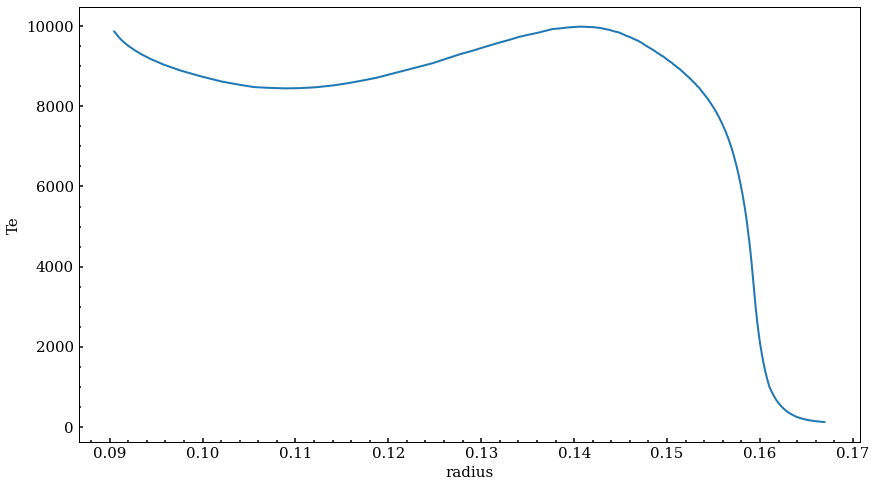

In [48]:
Plot(model_1).plot_random('ovr', 'radius', 'Te')

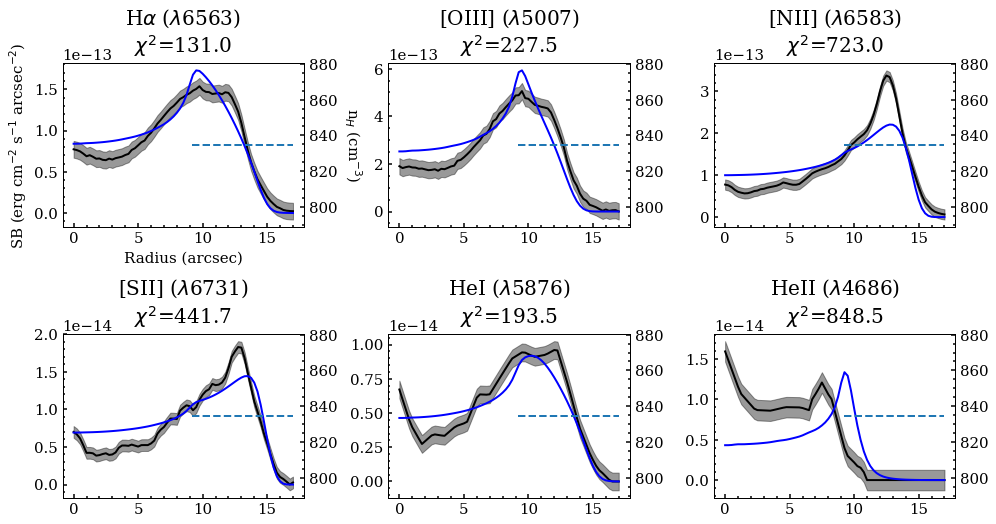

In [45]:
Plot(model_1).plot_sb_profiles(emis_lines=['Ha_6563', 'OIII_5007', 'NII_6583', 'SII_6731', 'HeI_5876', 'HeII_4686'], 
                      normalize=0, observations=1, from_file=0, save=0)